## Extinction example

In this example it is shown how to calculate the coherent elastic cross-section by accessing hkl information in NCrystal. The cross-section is then modified with the extinction parameter from the Sabine model [1].

[1] T. Sabine, International Tables for Crystallography C,
609 (2006).

## Preamble
Install dependencies and prepare plots. Feel free to edit as you wish:

In [1]:
#By default we only do pip installs on Google Colab, but you
#can set the variable in the next line to True if you need it:
always_do_pip_installs = False
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if always_do_pip_installs or google_colab:
    %pip -q install ncrystal[plot] ipympl pandas
#enable inline and interactive matplotlib plots:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
    %matplotlib inline
else:
    %matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  4000000, "too old NCrystal found"
NC.test() #< quick unit test that installation works

Tests completed succesfully


### Additional modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Example #1

We will compute the coherent elastic cross-section for 9Be through accessing hkl information in NCrystal. We will add that to the absorption and inelastic cross-section to compute the total cross-seciton

The coherent scattering cross-section is given by,
\begin{equation}
\sigma_{\textrm{coh}}^{\textrm{el}}(\lambda)=\dfrac{\lambda^{2}}{2V}\sum_{hkl}^{\lambda\leq 2d_{hkl}}d_{hkl}|F_{hkl}|^{2},
\end{equation}

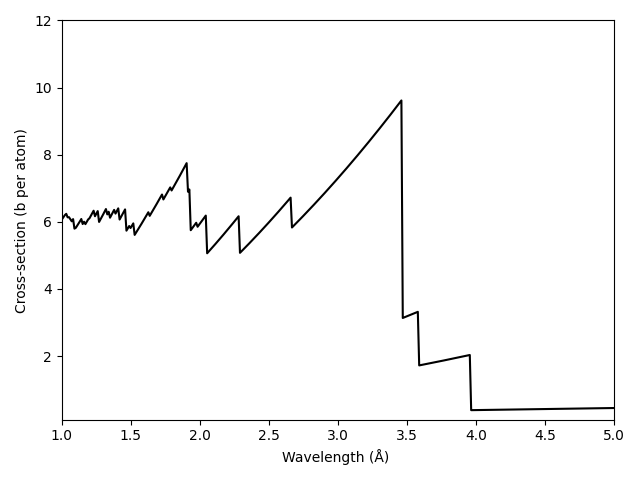

In [3]:
#-------------------------------------------------------------------------------
cfg1 = 'Be_sg194.ncmat;temp=293K'

info = NC.createInfo(cfg1)

wl = np.linspace(0.1,10.0,1000)
v0 = info.getStructureInfo()['volume']
atoms = info.getStructureInfo()['n_atoms']

coh_elas = np.zeros(len(wl))

pc = NC.createScatter( cfg1+";bragg=0")
pc_a = NC.createAbsorption( cfg1)

xsec_in = pc.xsect(wl=wl)
xsec_a = pc_a.xsect(wl=wl)

for e in info.hklObjects():
    coh_elas = coh_elas + e.d*e.f2*e.mult*(wl<=(2.0*e.d))*(wl*wl/2.0/v0/atoms)

xsec_total = coh_elas + xsec_in+xsec_a

plt.figure()
plt.plot(wl, xsec_total, 'black', label='9Be Total Cross-section')

plt.xlabel("Wavelength (Å) ")
plt.ylabel("Cross-section (b per atom)")
plt.xlim(1,5)
plt.ylim(0.1,12)
plt.show()

Compare the total cross section data with experimental data from the IAEA database [EXFOR](https://www-nds.iaea.org/exfor/). We will access the experimental data using the [Web API](https://www-nds.iaea.org/exfor/x4guide/API/).

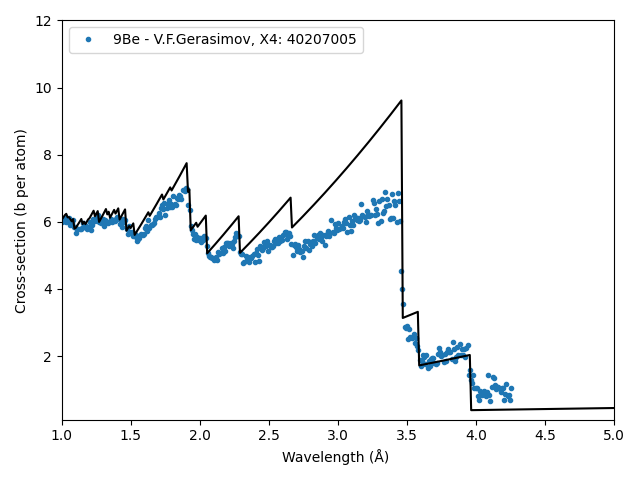

In [4]:
from urllib.request import urlopen, Request
import pandas as pd
import io
x4ids = [40207005]
x4label = ['9Be - V.F.Gerasimov']

plt.figure()
#for x4id in x4ids:
for i, x4id in enumerate(x4ids):
    req = Request(
        url=f'https://nds.iaea.org/exfor/x4get?DatasetID={x4id}&op=csv',
        data=None,
        headers={
            'User-Agent': 'Mozilla/5.0 (X11; Fedora; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
        }
    )
    with urlopen(req) as f:
        df = pd.read_csv(io.StringIO(f.read().decode('utf-8')))
    if 'EN (EV) 1.1' in list(df):
        x4_E, x4_xs = df['EN (EV) 1.1'].values, df['DATA (B) 0.1'].values
    elif 'EN (MEV) 1.1' in list(df):
        x4_E, x4_xs = 1e6*df['EN (MEV) 1.1'].values, df['DATA (B) 0.1'].values
    plt.plot(NC.ekin2wl(x4_E), x4_xs, '.', label=x4label[i]+ f', X4: {x4id}')

plt.legend(loc='upper left')
plt.xlim(1,5)
plt.ylim(0.1,12)
plt.plot(wl, xsec_total, 'black', label='9Be Total Cross-section')

plt.xlabel("Wavelength (Å) ")
plt.ylabel("Cross-section (b per atom)")
plt.show()

## Example #2

We will now include extinction using Sabine's model in the cross-section calculation.

The coherent scattering cross-section with extinction is given by,
\begin{equation}
\sigma_{\textrm{coh}}^{\textrm{el}}(\lambda)=\dfrac{\lambda^{2}}{2V}\sum_{hkl}^{\lambda\leq 2d_{hkl}}d_{hkl}|F_{hkl}|^{2}E_{hkl}(\lambda,F_{hkl}),
\end{equation}
with
\begin{equation}
E_{hkl}(\lambda,F_{hkl}) = E_{\textrm{L}}\cos^2(\theta_{hkl})+E_{\textrm{B}}\sin^2(\theta_{hkl}),
\end{equation}
and
\begin{equation}
  \theta_{hkl}=\arcsin\left(\dfrac{\lambda}{2d_{hkl}}\right),
\end{equation}
and
\begin{equation}
E_{\textrm{L}}=\begin{cases}
	\left(1-\dfrac{x}{2}+\dfrac{x^2}{4}-\dfrac{5x^3}{48}+\dfrac{7x^4}{192}\right),\quad x\leq1 \\
	\sqrt{\dfrac{2}{\pi x}}\left(1-\dfrac{1}{8x}-\dfrac{3}{128x^2}-\dfrac{15}{1024x^3}\right),\quad x>1
\end{cases},
\end{equation}
and
\begin{equation}
	E_{\textrm{B}}=\dfrac{1}{\sqrt{1+x}}.
\end{equation}
It is taken that $S$ is the crystallite size, $L$ the imperfect crystal size, and $g$ the mosaicity parameter. It is related to $x$ by
\begin{equation}
x=\left(\dfrac{S\lambda F_{hkl}}{V}+gQ_{\theta}(L-S) \right)^2
\end{equation}
where
\begin{equation}
Q_\theta=\dfrac{\lambda^3F_{hkl}^{2}}{V^2\sin(2\theta_{hkl})}.
\end{equation}

We define first the extinction function.

In [5]:
def PrimaryExtinction(d_ext,f_ext, w_ext,S,g,L):

    sin_theta = w_ext/2.0/d_ext
    sin_theta_2 = sin_theta**2
    cos_theta_2 = 1 - sin_theta_2

    if(sin_theta>=-1 and sin_theta<=1):
      sin2theta = 2.0*sin_theta*np.sqrt(cos_theta_2)
      Qtheta = w_ext*w_ext*w_ext*f_ext/v0/v0/sin2theta

      x = np.square(S*np.sqrt(f_ext)*(w_ext/v0)+ g*Qtheta*(L-S))

      e_b = 1.0/np.sqrt(1.0+x)
      if(x<=1.0):
           e_l = 1.0 - x/2.0 + x*x/4.0 - 5.0*x*x*x/48.0 + 7.0*x*x*x*x/192.0
      else:
           e_l = np.sqrt(2.0/np.pi/x)*(1.0 - 1.0/8.0/x - 3.0/128.0/x/x - 15.0/1024.0/x/x/x)
      out_ext=e_l*cos_theta_2+e_b*sin_theta_2
    else:
      out_ext = 1.0
    return  out_ext

Now we modify the above code to include the extinction factor.

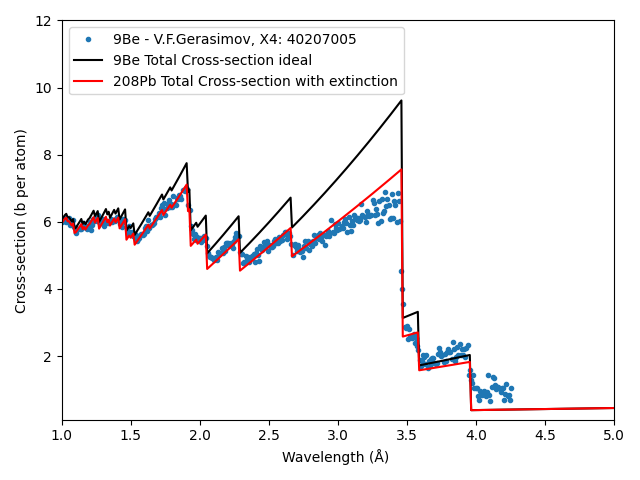

In [6]:
#Crystallite size
S=3.0 #crystallite size (microns)
L=10.0 #imperfect crystal size (microns)
g=0.0 #mosacity parameter

coh_elas = np.zeros(len(wl))
pc = NC.createScatter( cfg1+";bragg=0")
pc_a = NC.createAbsorption( cfg1)

xsec_in = pc.xsect(wl=wl)
xsec_a = pc_a.xsect(wl=wl)

for e in info.hklObjects():

    corr_extinction = np.vectorize(PrimaryExtinction)
    coh_elas = coh_elas + e.d*e.f2*e.mult*(wl<=(2.0*e.d))*(wl*wl/2.0/v0/atoms)*corr_extinction(e.d,e.f2,wl,S,g,L)

xsec_total_extinction = coh_elas + xsec_in+xsec_a

fig, ax = plt.subplots()
ax.plot(NC.ekin2wl(x4_E), x4_xs, '.', label=x4label[i]+ f', X4: {x4id}')
plt.plot(wl, xsec_total, 'black', label='9Be Total Cross-section ideal')
ax.plot(wl, xsec_total_extinction, 'r', label='208Pb Total Cross-section with extinction')
ax.set_xlabel("Wavelength (Å) ")
ax.set_ylabel("Cross-section (b per atom)")
plt.xlim(1,5)
plt.ylim(0.1,12)
ax.legend(loc='upper left')
plt.show()